This notebook implements finite difference propagation and compares its performance against Fresnel integral-based multislice simulation. Refer to the following paper for mathematical details:
1.	L. Melchior and T. Salditt, "Finite difference methods for stationary and time-dependent X-ray propagation," Optics Express 25, 32090– (2017).

In [14]:
import numpy as np
import dxchange
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyfftw.interfaces.numpy_fft import fft2, ifft2, fftshift, ifftshift
from scipy.misc import imresize
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage.filters import laplace, convolve
from time import time

In [47]:
PI = 3.1415927
def plot_img(a):
    plt.figure()
    plt.imshow(a)
    plt.show()

def plot_mod_and_phase(arr, figsize=(12, 5), title=None, unwrap=False):
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1, 2, 1)
    subfig1 = ax1.imshow(np.abs(arr))
    plt.colorbar(subfig1)
    plt.title('Modulus')
    ax2 = fig.add_subplot(1, 2, 2)
    phase_term = np.angle(arr)
    if unwrap:
        phase_term = np.unwrap(phase_term)
    subfig2 = ax2.imshow(phase_term)
    plt.colorbar(subfig2)
    plt.title('Phase')
    if title is not None:
        plt.suptitle(title)
    plt.show()

def laplacian(arr, algorithm='roll'):
    if algorithm == 'roll':
        arr_l = np.roll(arr, [0, -1], axis=[0, 1])
        arr_r = np.roll(arr, [0, 1], axis=[0, 1])
        arr_u = np.roll(arr, [-1, 0], axis=[0, 1])
        arr_d = np.roll(arr, [1, 0], axis=[0, 1])
        res = arr * 4 - arr_l - arr_r - arr_u - arr_d
    elif algorithm == 'convolution':
        kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
        res = convolve(np.real(arr), kernel) + 1j * convolve(np.imag(arr), kernel)
    else:
        raise ValueError
    return res

Again we have our MVP phantom object i.e. the cone model.

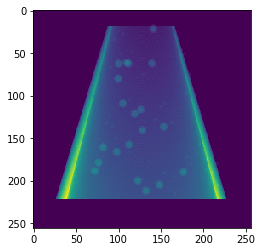

In [4]:
# read in object
grid_delta = np.load('phantom/grid_delta.npy')
grid_beta = np.load('phantom/grid_beta.npy')
# swap axis so that it is in [x, y, z] format
# grid_delta = np.swapaxes(grid_delta, 0, 1)
# grid_beta = np.swapaxes(grid_beta, 0, 1)
plot_img(np.sum(grid_delta, axis=2))

In [91]:
def finite_difference_propagation(wavefront, delta_slice, beta_slice, dist_nm, lmbda_nm, psize_nm):
    n_slice = 1 - delta_slice - 1j * beta_slice
    k = 2 * PI / lmbda_nm
    kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    dudz = 1 / (2j * k * n_slice) * \
           laplacian(wavefront, algorithm='convolution') / (psize_nm ** 2) - \
           1j * k * (n_slice - 1) * wavefront
    wavefront = wavefront + dudz * dist_nm
    return wavefront

In [92]:
def initialize_wavefront(psize_cm, probe_shape, wavelen_nm, type='plane', **kwargs):
    psize_nm = psize_cm * 1.e7
    if type == 'spherical':
        s_r_cm = kwargs['s_r_cm']
        s_r_nm = s_r_cm * 1.e7
        y, x = (np.arange(probe_shape[0], dtype='float64'), np.arange(probe_shape[1], dtype='float64'))
        y = (y - float(y[-1]) / 2) * psize_nm
        x = (x - float(x[-1]) / 2) * psize_nm
        xx, yy = np.meshgrid(x, y)
        r = np.sqrt(xx ** 2 + yy ** 2 + s_r_nm ** 2)
        wavefront = np.exp(-1j * 2 * PI * r / wavelen_nm)
    elif type == 'plane':
        wavefront = np.ones(probe_shape, dtype='complex128')
    return wavefront

Now we initialize the wavefront and propagate it through the object.

In [93]:
energy_ev = 5000.
psize_cm = 1e-7
psize_nm = psize_cm * 1.e7
lmbda_nm = 1240. / energy_ev

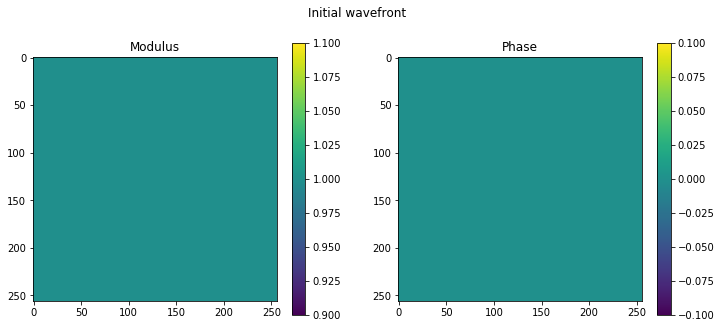

In [94]:
wavefront = initialize_wavefront(psize_cm, grid_delta.shape[0:2], lmbda_nm, type='plane')
plot_mod_and_phase(wavefront, title='Initial wavefront', unwrap=False)

100%|██████████| 256/256 [00:01<00:00, 149.52it/s]


1.7181019783


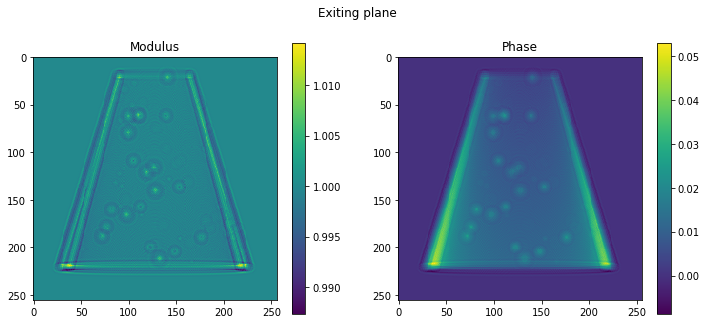

In [95]:
def multislice_propagate_fd(wavefront, grid_delta, grid_beta, lmbda_nm, psize_nm):
    for i_slice in tqdm(range(grid_delta.shape[2])):
        delta_slice = grid_delta[:, :, i_slice]
        beta_slice = grid_beta[:, :, i_slice]
        wavefront = finite_difference_propagation(wavefront, 
                                                  delta_slice,
                                                  beta_slice,
                                                  psize_nm, 
                                                  lmbda_nm,
                                                  psize_nm)
    return wavefront
t0 = time()
wavefront = multislice_propagate_fd(wavefront, grid_delta, grid_beta, lmbda_nm, psize_nm)
print(time() - t0)
plot_mod_and_phase(wavefront, title='Exiting plane', unwrap=False)

While it gives good result for this specific phantom, we will see that it fails for low energy and long distance due to numerical instability. For example, if we further propagate the result above in free space, the wavefront starts to be messed up. 

100%|██████████| 256/256 [00:00<00:00, 304.14it/s]


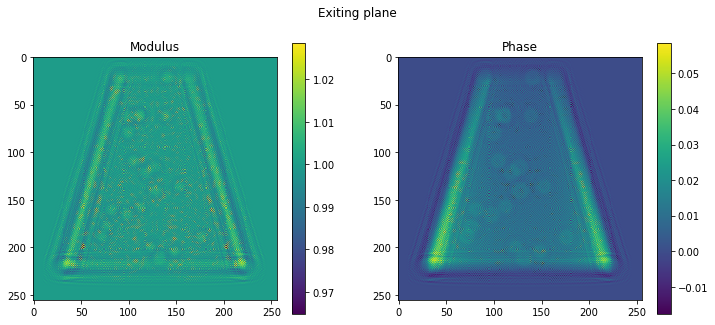

In [10]:
# this block shows how it fails at long distance. Low energy can also cause failure
for i_slice in tqdm(range(grid_delta.shape[2])):
    delta_slice =  np.zeros([256, 256])
    beta_slice = np.zeros([256, 256])
    wavefront = finite_difference_propagation(wavefront, 
                                              delta_slice,
                                              beta_slice,
                                              psize_nm, 
                                              lmbda_nm,
                                              psize_nm)
plot_mod_and_phase(wavefront, title='Exiting plane', unwrap=False)

Without solving the PDE exactly, there might be a way to reduce or prevent this effect. We can do this by first calculating the wavefront at the middle of two adjacent slices, and propagate it from there. 

In [37]:
# def finite_difference_propagation_precise(wavefront, this_delta_slice, this_beta_slice, next_delta_slice, next_beta_slice, dist_nm, lmbda_nm, psize_nm):
#     n_this_slice = 1 - this_delta_slice - 1j * this_beta_slice
#     n_next_slice = 1 - next_delta_slice - 1j * next_beta_slice
#     n_slice = (n_this_slice + n_next_slice) / 2
#     k = 2 * PI / lmbda_nm
#     kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
#     u_this = wavefront
#     dudz = 1 / (2j * k * n_slice) * \
#            (convolve(np.real(u_this), kernel) + 1j * convolve(np.imag(u_this), kernel)) / (psize_nm ** 2) - \
#            1j * k * (n_slice - 1) * u_this
#     u_next = u_this + dudz * dist_nm
#     dudz = 1 / (2j * k * n_slice) * \
#            ((convolve(np.real(u_this), kernel) + 1j * convolve(np.imag(u_this), kernel)) / (psize_nm ** 2) +
#             (convolve(np.real(u_next), kernel) + 1j * convolve(np.imag(u_next), kernel)) / (psize_nm ** 2)) / 2. - \
#            1j * k * (n_slice - 1) * u_this
#     wavefront = wavefront + dudz * dist_nm
#     return wavefront

# def multislice_propagate_fd_precise(wavefront, grid_delta, grid_beta, lmbda_nm, psize_nm):
#     for i_slice in tqdm(range(grid_delta.shape[2] - 1)):
#         this_delta_slice = grid_delta[:, :, i_slice]
#         this_beta_slice = grid_beta[:, :, i_slice]
#         next_delta_slice = grid_delta[:, :, i_slice + 1]
#         next_beta_slice = grid_beta[:, :, i_slice + 1]
#         wavefront = finite_difference_propagation_precise(wavefront, 
#                                                           this_delta_slice,
#                                                           this_beta_slice,
#                                                           next_delta_slice,
#                                                           next_beta_slice,
#                                                           psize_nm, 
#                                                           lmbda_nm,
#                                                           psize_nm)
#     return wavefront

In [81]:
def finite_difference_propagation_precise(wavefront, this_delta_slice, this_beta_slice, next_delta_slice, next_beta_slice, dist_nm, lmbda_nm, psize_nm, laplacian_u_this=None):
    n_this_slice = 1 - this_delta_slice - 1j * this_beta_slice
    n_next_slice = 1 - next_delta_slice - 1j * next_beta_slice
    n_slice = (n_this_slice + n_next_slice) / 2
    k = 2 * PI / lmbda_nm
    u_this = wavefront
    if laplacian_u_this is None:
        laplacian_u_this = laplacian(u_this)
    dudz = 1 / (2j * k * n_slice) * \
           laplacian_u_this / (psize_nm ** 2) - \
           1j * k * (n_slice - 1) * u_this
    u_next = u_this + dudz * dist_nm
    laplacian_u_next = laplacian(u_next, algorithm='roll')
    dudz = 1 / (2j * k * n_slice) * \
           (laplacian_u_this / (psize_nm ** 2) +
            laplacian_u_next / (psize_nm ** 2)) / 2. - \
           1j * k * (n_slice - 1) * u_this
    wavefront = wavefront + dudz * dist_nm
    return wavefront, laplacian_u_next

def multislice_propagate_fd_precise(wavefront, grid_delta, grid_beta, lmbda_nm, psize_nm):
    laplacian_u_this = laplacian(wavefront)
    for i_slice in tqdm(range(grid_delta.shape[2] - 1)):
        this_delta_slice = grid_delta[:, :, i_slice]
        this_beta_slice = grid_beta[:, :, i_slice]
        next_delta_slice = grid_delta[:, :, i_slice + 1]
        next_beta_slice = grid_beta[:, :, i_slice + 1]
        wavefront, laplacian_u_this = finite_difference_propagation_precise(wavefront, 
                                                                            this_delta_slice,
                                                                            this_beta_slice,
                                                                            next_delta_slice,
                                                                            next_beta_slice,
                                                                            psize_nm, 
                                                                            lmbda_nm,
                                                                            psize_nm,
                                                                            laplacian_u_this=laplacian_u_this)
    return wavefront

100%|██████████| 767/767 [00:09<00:00, 84.48it/s]


9.08518695831


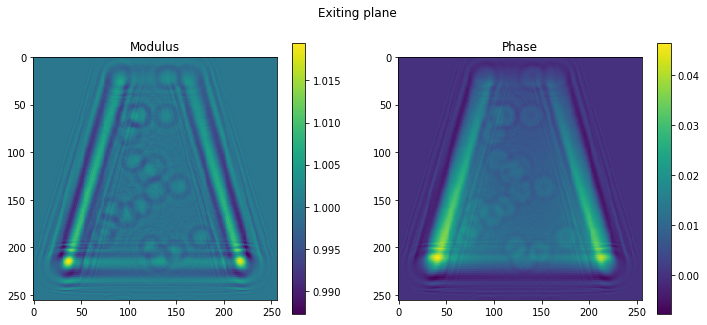

In [83]:
grid_delta_extended = np.concatenate([grid_delta, np.zeros([256, 256, 512])], axis=2)
grid_beta_extended = np.concatenate([grid_beta, np.zeros([256, 256, 512])], axis=2)
wavefront = initialize_wavefront(psize_cm, grid_delta.shape[0:2], lmbda_nm, type='plane')
t0 = time()
wavefront = multislice_propagate_fd_precise(wavefront, grid_delta_extended, grid_beta_extended, lmbda_nm, psize_nm)
# wavefront = multislice_propagate_fd_precise(wavefront, grid_delta, grid_beta, lmbda_nm, psize_nm)
print(time() - t0)
plot_mod_and_phase(wavefront, title='Exiting plane', unwrap=False)